# **DNA assembly**

### **Librerias**

In [129]:
import networkx as nx
import ipywidgets as widgets
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import display

### **Paso 1: Definir los conjuntos de k-mers y un selector interactivo**

In [146]:
# Lista de conjuntos de k-mers
kmers_list = [
    ["GACG", "GCTT", "TTAC", "ACTA", "TATG", "TGTG"],  # Primer conjunto con fallo por falta de conectividad
    ["AGTC", "GTCA", "TCAG", "CAGT", "AGTT", "GTTG"],  # Segundo conjunto de k-mers
    ["AGTT", "GTTG", "TTGA", "TGAC", "GACG", "ACGA", "CGAA", "GAAC", "AACG"]  # Tercer conjunto de k-mers
]

# Crear un dropdown para seleccionar el conjunto de k-mers
kmers_selector = widgets.Dropdown(
    options=[(f"Conjunto {i+1}", i) for i in range(len(kmers_list))],
    value=0,  # Índice predeterminado
    description="Selecciona k-mers:",
    style={'description_width': 'initial'}
)

# Mostrar el widget
display(kmers_selector)


Dropdown(description='Selecciona k-mers:', options=(('Conjunto 1', 0), ('Conjunto 2', 1), ('Conjunto 3', 2)), …

### **Paso 2: Construir el Grafo de De Bruijn usando el conjunto seleccionado**

In [154]:
def build_de_bruijn_graph(kmers):
    G = nx.DiGraph()
    for kmer in kmers:
        prefix = kmer[:-1]
        suffix = kmer[1:]
        G.add_edge(prefix, suffix, label=kmer)
    return G

# Obtener el conjunto de k-mers seleccionado y construir el grafo
kmers = kmers_list[kmers_selector.value]
G = build_de_bruijn_graph(kmers)
print("Conjunto de k-mers seleccionado:", kmers)
print("Grafo de De Bruijn construido:", G.edges(data=True))


Conjunto de k-mers seleccionado: ['AGTC', 'GTCA', 'TCAG', 'CAGT', 'AGTT', 'GTTG']
Grafo de De Bruijn construido: [('AGT', 'GTC', {'label': 'AGTC'}), ('AGT', 'GTT', {'label': 'AGTT'}), ('GTC', 'TCA', {'label': 'GTCA'}), ('TCA', 'CAG', {'label': 'TCAG'}), ('CAG', 'AGT', {'label': 'CAGT'}), ('GTT', 'TTG', {'label': 'GTTG'})]


### **Paso 3: Verificar si hay Camino o Ciclo Euleriano**

In [155]:
def has_eulerian_path_or_cycle(G):
    in_degrees = Counter(G.in_degree(n) for n in G.nodes())
    out_degrees = Counter(G.out_degree(n) for n in G.nodes())

    start_nodes = [n for n in G.nodes() if G.out_degree(n) - G.in_degree(n) == 1]
    end_nodes = [n for n in G.nodes() if G.in_degree(n) - G.out_degree(n) == 1]
    balanced_nodes = [n for n in G.nodes() if G.in_degree(n) == G.out_degree(n)]

    if len(start_nodes) == 1 and len(end_nodes) == 1:
        return "path", start_nodes[0], end_nodes[0]
    elif not start_nodes and not end_nodes and len(balanced_nodes) == len(G.nodes()):
        return "cycle", None, None
    else:
        return None, start_nodes, end_nodes

# Verificar si hay un camino o ciclo Euleriano en el grafo construido
graph_type, start_node, end_node = has_eulerian_path_or_cycle(G)
if graph_type:
    print(f"El grafo tiene un {graph_type} Euleriano.")
else:
    print("No se encontró un camino o ciclo Euleriano.")


El grafo tiene un path Euleriano.


### **Paso 4: Encontrar Camino o Ciclo Euleriano**

In [156]:
def find_eulerian_path_or_cycle(G):
    graph_type, start_node, end_node = has_eulerian_path_or_cycle(G)
    
    if graph_type == "path":
        return list(nx.eulerian_path(G, source=start_node)), graph_type
    elif graph_type == "cycle":
        return list(nx.eulerian_circuit(G)), graph_type
    else:
        return None, None

# Buscar el camino o ciclo Euleriano si existe
path, graph_type = find_eulerian_path_or_cycle(G)
if path:
    print(f"{'Camino' if graph_type == 'path' else 'Ciclo'} Euleriano encontrado:", path)
else:
    print("No se encontró un camino o ciclo Euleriano en el grafo.")


Camino Euleriano encontrado: [('AGT', 'GTC'), ('GTC', 'TCA'), ('TCA', 'CAG'), ('CAG', 'AGT'), ('AGT', 'GTT'), ('GTT', 'TTG')]


### **Paso 5: Reconstrucción de la Secuencia de ADN**

In [157]:
def reconstruct_sequence_from_path(path):
    sequence = path[0][0]
    for _, suffix in path:
        sequence += suffix[-1]
    return sequence

# Reconstruir la secuencia de ADN si se encontró un camino o ciclo Euleriano
if path:
    assembled_sequence = reconstruct_sequence_from_path(path)
    print("Secuencia ensamblada a partir del camino/ciclo Euleriano:", assembled_sequence)
else:
    print("No hay camino o ciclo Euleriano para reconstruir la secuencia.")


Secuencia ensamblada a partir del camino/ciclo Euleriano: AGTCAGTTG


### **Paso 6: Análisis de Errores en Caso de Fallo**

In [158]:
def analyze_errors(G):
    in_degrees = {n: G.in_degree(n) for n in G.nodes()}
    out_degrees = {n: G.out_degree(n) for n in G.nodes()}

    unbalanced_nodes = [n for n in G.nodes() if in_degrees[n] != out_degrees[n]]
    if unbalanced_nodes:
        print("El grafo no tiene camino o ciclo Euleriano debido a nodos no balanceados.")
        print(f"Nodos no balanceados: {unbalanced_nodes}")
        for node in unbalanced_nodes:
            print(f"Nodo {node} tiene {in_degrees[node]} aristas de entrada y {out_degrees[node]} aristas de salida.")
    else:
        print("El grafo es balanceado pero puede estar desconectado.")

# Ejecutar el análisis de errores si no se encontró un camino o ciclo Euleriano
if not path:
    analyze_errors(G)


### **Paso 7: Visualización del Grafo de De Bruijn**

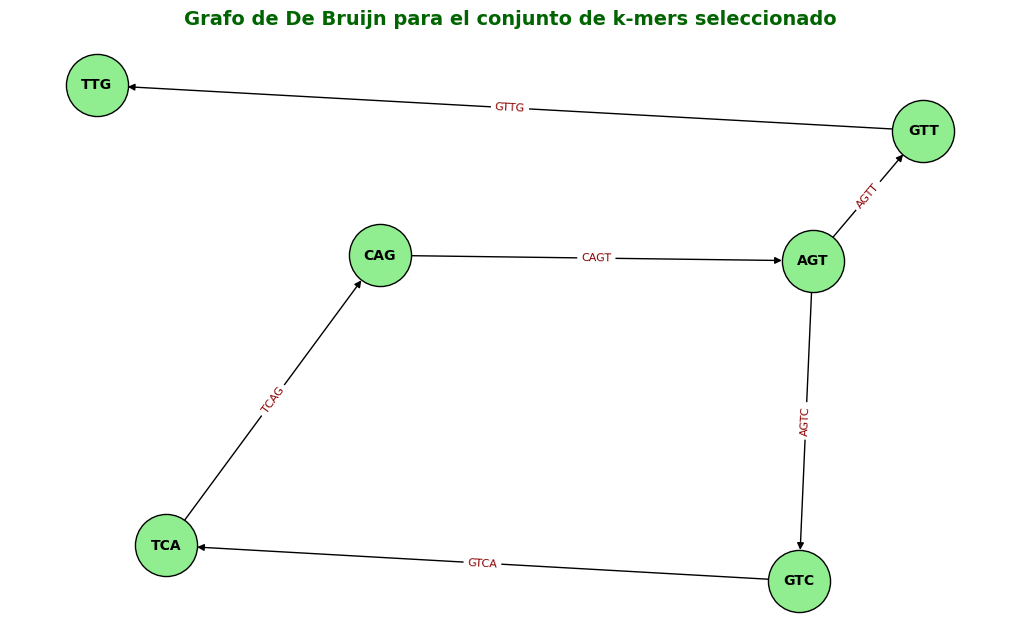

In [159]:
def visualize_graph(G, title="Grafo de De Bruijn"):
    pos = nx.spring_layout(G, k=1.5, seed=42)
    plt.figure(figsize=(10, 6))
    
    # Dibujar nodos y aristas
    nx.draw(G, pos, with_labels=True, node_color="lightgreen", node_size=2000, 
            font_size=10, font_weight="bold", edge_color="black", edgecolors='black', arrows=True)

    # Etiquetas de las aristas
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color="darkred")

    # Título y visualización
    plt.title(title, fontsize=14, fontweight="bold", color="darkgreen")
    plt.show()

# Visualizar el grafo de De Bruijn
visualize_graph(G, f"Grafo de De Bruijn para el conjunto de k-mers seleccionado")
